# Desafio 6 - PFSP IG - Dupla 09

**Integrantes:**

* Lucas Hideki Takeuchi Okamura NUSP: 9274315

* Thales Arantes Kerche Nunes NUSP: 10769372

**Objetivo**

* Programar a meta-heurística Iterated Greedy (Ruiz & Stützle, 2007) para o problema de minimização do makespan em um flow shop com m máquinas, tendo como solução inicial a solução gerada por NEH + LS.

**Descrição**

* O método baseia-se em um processo de destrução e reconstrução da solução corrente do problema

* Em cada iteração, são retirados aleatoriamente "d" jobs da solução corrente; estes jobs são, em seguida, reinseridos um a um em processo análogo ao da heurística construtiva NEH

* A meta-heurística utiliza um critério de aceitação de soluções parciais semelhante ao de heurísticas simulated annealing

* O critério de aceitação estabelece que: i) se a solução gerada na iteração é melhor que a solução corrente, aceita-se a nova solução ii) se a solução gerada na iteração é pior, há uma probabilidade de aceitação que descresce exponencialmente com a qualidade da nova solução

* Deve-se definir um critério de parada que pode ser por tempo ou número de iterações

* A meta-heurística tem três parâmetros para sua operação i) "d" - número de jobs retirados na desconstrução ii) "T" - "temperatura" utilizada no critério de aceitação, que irá definir o caimento exponencial da probabilidade de aceitação iii) número de iterações sem melhoria para parada da meta-heurística

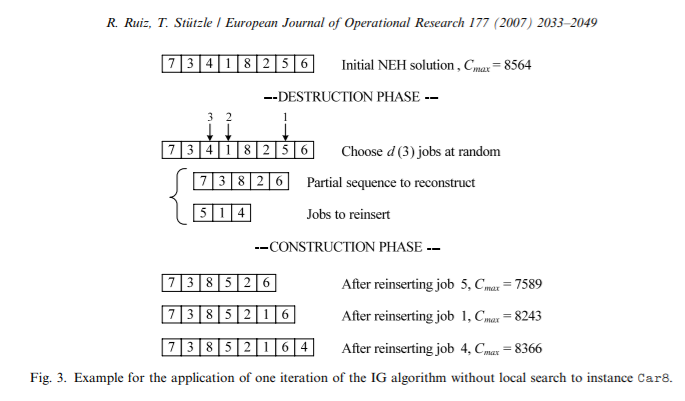

In [1]:
import xlwings as xw
import numpy as np

## 1. Definindo a Classe Job

In [2]:
class Job:
    def __init__(self,i,p):
        self.i=i     # número do job, pela ordem de chegada
        self.p=p     # processing times [p1,p2]
        self.C=[]     # completion times [c1,c2]
        self.psum = np.sum(self.p)     # sum of values of p

## 2. Definindo Funções

**Função para o cálculo dos tempos de conclusão dos jobs em cada uma das m máquinas**

$p_{(j)k}:$ processing time do job da posição j na máquina k

$c_{(j)k}:$ completion time do job da posição j na máquina k

$c_{(1)1} = p_{(1)1}$

$c_{(1)k}=c_{(1),k−1}+p_{(1)k}$, onde    $k=2,...,m$

$c_{(j)1}=c_{(j−1)1}+p_{(j)1}$, onde $j=2,...,n$

$c_{(j)k}=max\left\{{c_{(j),k−1},c_{(j−1)k}}\right\} +p_{(j)k}$, onde $j=2,...,n$ e $k=2,...,m$

In [3]:
def calcCmax(m,jobs):     # esta função calcula os tempos de conclusão dos jobs nas m máquinas
    n=len(jobs)
    c=[[0 for i in range(m)] for j in range(n)]
    p=[job.p for job in jobs]
    
    # primeiro job
    c[0][0]=p[0][0]     # primeira máquina
    for k in range(1,m):     # próximas máquinas
        c[0][k]=c[0][k-1]+p[0][k]
        
    # próximos jobs
    for j in range(1,n):
        c[j][0]=c[j-1][0]+p[j][0]     # primeira máquina
        for k in range(1,m):     # próximas máquinas
            c[j][k]=max(c[j][k-1],c[j-1][k])+p[j][k]
            
    j=0
    for job in jobs:
        job.C=c[j]
        j+=1
    
    return c[-1][-1]

**Entrada de Dados**

In [4]:
def leInst(i):
    plan = wb1.sheets[i]
    n=int(plan.range('B6').value)
    m=int(plan.range('B5').value)
    Cmax = int(plan.range('F5').value)
    tab=plan.range('A11').expand('table').value
    jobs=[]
    for j in range(n):
        p=tab[j][1:-5]
        jobs.append(Job(tab[j][0]-1,p))
        
    print()
    #print('#','p')
    #for job in jobs:
        #print(job.i, job.p)
    
    return jobs, m, n, Cmax

**Saída de resultados**

In [5]:
def gravaSched(i,jobs,Cmax):
    n=len(jobs)
    tab=[]
    for job in jobs:
        a=[job.i+1]+job.p+job.C
        tab.append(a)

    if i==0:
        plan=wb2.sheets[0]
        plan.name='I(1)'
    else:
        plan=wb2.sheets.add('I('+str(i+1)+')',after=i)
        
    plan.range('A5').value=['m',m]
    plan.range('A6').value=['n',n]
    plan.range('E5').value=['Cmax',Cmax]
    plan.range('A10').value=['#','p1','p2','p3','p4','p5','C1','C2','C3','C4','C5']
    plan.range('A11').value=tab

    print()
    # print('#','p','C')
    # for job in jobs:
    #    print(job.i, job.p, job.C)
    print('Cmax:',Cmax)

**Calcula Temperatura**

In [6]:
def Temperature(T, jobs, m):
    n = len(jobs)
    temperature = T * np.sum([job.psum for job in jobs])/(10* n * m)
    
    return temperature

**Encontrar melhor permutação**

In [7]:
def findBestPerm(jobs, job_insert):
    bestCmax = np.inf
    
    for j in range(len(jobs) + 1):
        jobs.insert(j, job_insert)
        Cmax_test = calcCmax(m, jobs)
        if Cmax_test < bestCmax:
            bestPos = j
            bestCmax = Cmax_test
        jobs.pop(j)
    jobs.insert(bestPos, job_insert)
                
    return jobs, bestCmax

**Algoritmo IG**

In [21]:
def schedIG(jobs, m, Cmax, iter_lim, T, d):    
    # Calculando soma das somas de valores p
    temperature = Temperature(T, jobs, m)
    
    best_jobs = jobs[:]
    
    n = len(jobs)
    
    for lim in range(iter_lim):
        jobs1 = best_jobs[:]
        job_pop = np.random.choice(jobs1, size = d, replace = False)
        
        # Removendo jobs selecionados da lista original
        for job in job_pop:
            jobs1.remove(job)
        
        for job in job_pop:
            jobs1, testCmax = findBestPerm(jobs1, job)
            
        if testCmax < calcCmax(m, best_jobs):
            best_jobs = jobs1[:]
            
        elif np.random.random_sample() <= np.exp(-testCmax - calcCmax(m, best_jobs)) / temperature:
            best_jobs = jobs1[:]
            
    return best_jobs, calcCmax(m, best_jobs)

## 3. Testando com Dados do Excel

Instância de teste menor (aula)

In [22]:
ps = [[6, 3],
      [1, 3],
      [8, 6],
      [2, 5],
      [4, 6]]

jobs_test = []
n = len(ps)
m = len(ps[0])

for i in range(n):
    jobs_test.append(Job(i, ps[i]))
    
Cmax = calcCmax(m, jobs_test)
T = 0.5
d = 3
    
jobs_test, bestCmax = schedIG(jobs_test, m, Cmax, iter_lim = 100, T = T, d = d)

print('#','p','C')
for job in jobs_test:
    print(job.i, job.p, job.C)
print('Cmax:',bestCmax)

# p C
1 [1, 3] [1, 4]
3 [2, 5] [3, 9]
4 [4, 6] [7, 15]
2 [8, 6] [15, 21]
0 [6, 3] [21, 24]
Cmax: 24


Instâncias de teste Excel

In [26]:
wb1 = xw.Book('xl10 2 B PFSP Cmax NEH-LS.xlsx')
wb2 = xw.Book()
I = wb1.sheets.count     # número de instância é igual ao número de planilhas na pasta

for i in range(I):
    print()
    print(i+1)
    jobs, m, n, Cmax = leInst(i)
    jobs, Cmax = schedIG(jobs, m, Cmax, iter_lim = 100, T = 0.5, d = 3)
    gravaSched(i,jobs,Cmax)
    
wb2.save('xl11 2 B PFSP Cmax IG.xlsx')


1


Cmax: 1174.0

2


Cmax: 1269.0

3


Cmax: 1147.0

4


Cmax: 1147.0

5


Cmax: 1252.0

6


Cmax: 1171.0

7


Cmax: 1290.0

8


Cmax: 1189.0

9


Cmax: 1273.0

10


Cmax: 1175.0


## 4. Comparação NEH + LS e IG
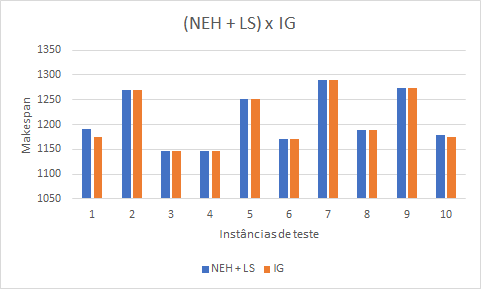

Assim, observa-se que para instâncias I(1) e I(10), o método de _Iterated Greedy_ mostrou um aprimoramento em relação ao _NEH + LS_.